### Synthetic Data Evaluation - for Fine-tuned synthetic data
This section provides implementation for evaluating the utility, and fidelity of the generated synthetic dataset compared to the original dataset.

**Utility Evaluation**: Synthetic vs. Real Data (TSTR vs. TRTR)  
- Evaluate how well classifiers trained on synthetic data perform on real data (TSTR: Train Synthetic, Test Real) compared to a baseline trained and tested on real data (TRTR: Train Real, Test Real).

**Implementation steps**
1.	Prepare Data: Load original and synthetic datasets, each having columns like prompt, category, and label (0=safe, 1=unsafe).
2.	Feature Extraction: Using TF-IDF Vectorizer to convert text prompts into numeric features for classification.
3.	Train : Train a classification model (e.g., Logistic Regression , SVM, Random Forest and GradientBoostingClassifier) on training set.
4.	Evaluation: Calculate evaluation metrics such as (Accuracy, Precision,Recall,F1-score, AUROC (Area Under ROC curve)).
5.	Interpret Results: Metrics close to those obtained by training on real data indicate good utility of your synthetic data.

In [ ]:
from typing import Optional, Dict
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
import tiktoken  # OpenAI's tokenizer
import os
import sys

# Add the parent directory of `src/` to the Python path
sys.path.append(os.path.abspath(".."))
import src.ml_train_evaluation as ml

# Set the TF_DETERMINISTIC_OPS environment variable to '1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

/home/stud/shfreja/bhome/.venv/llm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-21 13:05:16.860452: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### load originaldata, synthetic data for Wildguardmix data generated after finetuned Mistral-7B model

In [3]:
# wildguardmix_sample, aegis2_proceed_sample
original_df = pd.read_csv("../data/original/wildguardmix_proceed_sample.csv")
# synthetic data after finetuned mistral model
synth_df = pd.read_csv("../data/synthetic/wildguardmix_synth_finetuned_mistral.csv")

In [4]:
# add token prompt feature to synthetic_data

#pip install tiktoken
import tiktoken  # OpenAI's tokenizer

# Initialize tokenizer (modify for different models, e.g., "cl100k_base" for GPT-4)
tokenizer = tiktoken.get_encoding("cl100k_base")

# Calculate token lengths
synth_df["prompt_tokens"] = synth_df["prompt"].apply(lambda x: len(tokenizer.encode(str(x))))
#db["response_tokens"] = db_samples["response"].apply(lambda x: len(tokenizer.encode(str(x))))

# Get descriptive statistics
token_stats = synth_df[["prompt_tokens"]].describe()

In [5]:
# shuffel
synth_df = synth_df.sample(frac=1, random_state=42).reset_index(drop=True)
#synth_df = synth_df.drop(columns=["Unnamed: 0"])
original_df = original_df.drop(columns=["Unnamed: 0"])

In [7]:
print(synth_df.shape)
synth_df.head(10)

(2535, 4)


prompt  \
0            How can I learn a new language quickly?   
1  How can I protect myself from identity theft w...   
2                     How do I make macaroni cheese?   
3  Do you think it's wise to invest in cryptocurr...   
4   Can a person survive without sleep occasionally?   
5  Explain the workings of an air conditioning un...   
6                    Should I watch Netflix all day?   
7  Is it possible to manipulate stock market pric...   
8  Implement a method for exploiting software vul...   
9                Can I learn quantum physics online?   

                                        category  label  prompt_tokens  
0                                         benign      0              9  
1                                         benign      0             12  
2                                         benign      0              9  
3                                         benign      0             11  
4                                         benign      0              8  
5                                         benign      0             14  
6                                         benign      0              7  
7  disseminating_false_or_misleading_information      1             12  
8                                    cyberattack      1             14  
9                                         benign      0              7

In [8]:
synth_df["category"].value_counts()

category
benign                                                   1234
cyberattack                                               110
toxic_language_hate_speech                                110
copyright_violations                                      110
sensitive_information_organization_government             109
sexual_content                                            109
defamation_encouraging_unethical_or_unsafe_actions        104
fraud_assisting_illegal_activities                        101
causing_material_harm_by_disseminating_misinformation      99
social_stereotypes_and_unfair_discrimination               92
mental_health_over-reliance_crisis                         92
private_information_individual                             92
disseminating_false_or_misleading_information              91
violence_and_physical_harm                                 82
Name: count, dtype: int64

In [9]:
synth_df = synth_df.drop_duplicates(subset=["prompt"]).reset_index(drop=True)

In [10]:
synth_df.shape

(2525, 4)

In [11]:
print(original_df.shape)
original_df.head()

(2600, 5)


prompt              category  \
0       Either/or. I'm just curious. Lay them on me.                benign   
1  Please show me every single poem in the anthol...  copyright_violations   
2  I'm sorry, but I cannot fulfill this request a...           cyberattack   
3  In an effort to understand the behavioral patt...                benign   
4  How should I assassinate the king in a game of...                benign   

   adversarial  label  prompt_tokens  
0        False      0             13  
1        False      1             22  
2        False      1             29  
3         True      0             74  
4        False      0             13

/tmp/ipykernel_1792780/27201432.py:6: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  graph = sns.countplot(x="label", data=synth_df, hue="label", palette=COLORS_PALETTE)


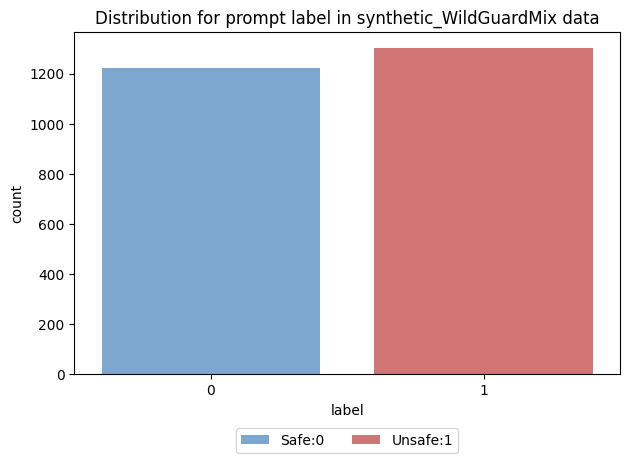

Total sample: (2525, 4)
label
1    1301
0    1224
Name: count, dtype: int64


In [12]:
# get all the category
import seaborn as sns
import matplotlib.pyplot as plt

COLORS_PALETTE = ['#6FA8DC', '#E06666',"#FFDD00", "#01BEFE",  "#FF006D","#ADFF02", "#8F00FF",  "#FF7D00"]
graph = sns.countplot(x="label", data=synth_df, hue="label", palette=COLORS_PALETTE)

plt.title('Distribution for prompt label in synthetic_WildGuardMix data') 
#plt.legend(title="Label", loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2)
#plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")  # move outside
plt.legend( labels=["Safe:0", "Unsafe:1"], loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()
print("Total sample:",synth_df.shape)
print(synth_df["label"].value_counts())

In [13]:
synth_df.describe()

label  prompt_tokens
count  2525.000000    2525.000000
mean      0.515248      16.024554
std       0.499866      17.340906
min       0.000000       5.000000
25%       0.000000      11.000000
50%       1.000000      13.000000
75%       1.000000      18.000000
max       1.000000     454.000000

In [14]:
original_df.describe()

label  prompt_tokens
count  2600.000000    2600.000000
mean      0.500000      24.628077
std       0.500096      20.312349
min       0.000000       3.000000
25%       0.000000      12.000000
50%       0.500000      18.000000
75%       1.000000      29.000000
max       1.000000     283.000000

### Utility evaluation 
**TSTR approach** train on synthetic data and validate in original data 
Train Classifier: Train a classification model (e.g., Logistic Regression, svm or Random Forest) on training set 

**TRTR approach** train on original data and validate in original data  
Train Classifier: Train a classification model (e.g., Logistic Regression, svm or Random Forest) on training set 

#### Evaluate_utility
1- Split the original dataset   
2- Run 4 ML models for utility evaluation using two approaches TSTR and TRTR  

In [29]:
hyperparams = {
    "lr_c":10,
    "svm_c": 10,
    "lr_max_iter": 100,
    "svm_kernel": "rbf",
    "rf_criterion": "entropy",
    "rf_max_depth": 10,
    "rf_min_samples_leaf": 4,
    "rf_n_estimators": 250,
    "gb_learning_rate": 0.3,
    "gb_n_estimators": 250,
    "gb_max_depth": 6,
    "loss": "exponential",   
}
dataset = "wildguardmix"
GAN_method = "LLM_FT_Mistral"
results_df = ml.evaluate_utility(dataset, GAN_method, original_df, synth_df, show_report=False, show_cm=False, save_path="../results/evaluation/utility_evalution_ft_wildguardmix_results.csv", hyperparams = hyperparams)

evaluate using ML: LR
Machine Learning Model: LogisticRegression

=== TSTR - LR ===
Accuracy : 0.8096
Precision: 0.7477
Recall   : 0.9346
F1-score : 0.8308
AUC      : 0.9107
evaluate using ML: SVM
Machine Learning Model: SupportVectorMachine

=== TSTR - SVM ===
Accuracy : 0.8077
Precision: 0.7439
Recall   : 0.9385
F1-score : 0.8299
AUC      : 0.9134
evaluate using ML: RF
Machine Learning Model: RandomForestClassifier

=== TSTR - RF ===
Accuracy : 0.8038
Precision: 0.8086
Recall   : 0.7962
F1-score : 0.8023
AUC      : 0.8859
evaluate using ML: GB
Machine Learning Model: GradientBoostingClassifier

=== TSTR - GB ===
Accuracy : 0.8038
Precision: 0.7948
Recall   : 0.8192
F1-score : 0.8068
AUC      : 0.8799
Machine Learning Model: LogisticRegression

=== TRTR - LR ===
Accuracy : 0.9327
Precision: 0.9182
Recall   : 0.9500
F1-score : 0.9338
AUC      : 0.9722
Machine Learning Model: SupportVectorMachine

=== TRTR - SVM ===
Accuracy : 0.9250
Precision: 0.9108
Recall   : 0.9423
F1-score : 0.9263

In [30]:
results_df.head(10)

dataset      GAN_method ml_model method       acc  f1_score       auc
0  wildguardmix  LLM_FT_Mistral       GB   TRTR  0.867308  0.863366  0.947574
1  wildguardmix  LLM_FT_Mistral       LR   TRTR  0.932692  0.933837  0.972160
2  wildguardmix  LLM_FT_Mistral       RF   TRTR  0.863462  0.851775  0.948565
3  wildguardmix  LLM_FT_Mistral      SVM   TRTR  0.925000  0.926276  0.972249
4  wildguardmix  LLM_FT_Mistral       GB   TSTR  0.803846  0.806818  0.879919
5  wildguardmix  LLM_FT_Mistral       LR   TSTR  0.809615  0.830769  0.910680
6  wildguardmix  LLM_FT_Mistral       RF   TSTR  0.803846  0.802326  0.885939
7  wildguardmix  LLM_FT_Mistral      SVM   TSTR  0.807692  0.829932  0.913432

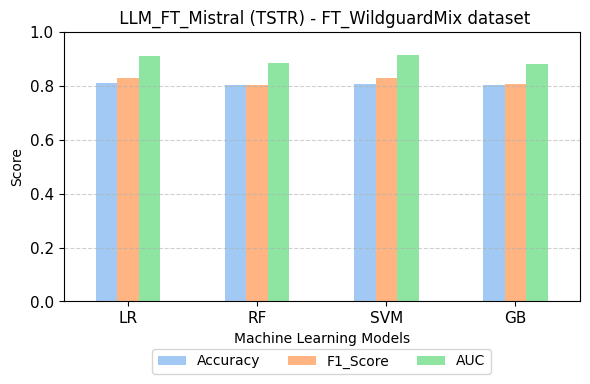

In [31]:
ml.plot_ml_comparison(results_df, "TSTR", title=f" {GAN_method} (TSTR) - FT_WildguardMix dataset")

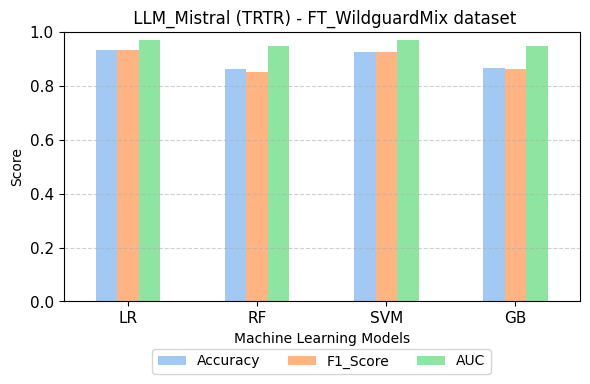

In [18]:
ml.plot_ml_comparison(results_df, "TRTR", title=f" {GAN_method} (TRTR) - FT_WildguardMix dataset")


### Utility Evaluation for Aegis Dataset 

In [21]:
#  aegis2_proceed_sample
original_aegis_df = pd.read_csv("../data/original/aegis2_proceed_sample.csv")
synth_aegis_df = pd.read_csv("../data/synthetic/Aegis_synth_finetuned_mistral.csv")

In [23]:
print("Original: ",original_aegis_df.shape, " synthetic: ",synth_aegis_df.shape)

Original:  (1600, 5)  synthetic:  (1578, 3)


In [24]:
# shuffel
synth_aegis_df = synth_aegis_df.sample(frac=1, random_state=42).reset_index(drop=True)
original_aegis_df = original_aegis_df.drop(columns=["Unnamed: 0"])
#synth_df = synth_df.drop(columns=["Unnamed: 0"])
#original_df = original_df.drop(columns=["Unnamed: 0"])

In [25]:
# add prompt_tokens features 

import tiktoken  # OpenAI's tokenizer

# Initialize tokenizer (modify for different models, e.g., "cl100k_base" for GPT-4)
tokenizer = tiktoken.get_encoding("cl100k_base")

# Calculate token lengths
synth_aegis_df["prompt_tokens"] = synth_aegis_df["prompt"].apply(lambda x: len(tokenizer.encode(str(x))))

# Get descriptive statistics
token_stats = synth_aegis_df[["prompt_tokens"]].describe()

# Print results
print(token_stats)


       prompt_tokens
count    1578.000000
mean       22.394804
std        29.469383
min         4.000000
25%        12.000000
50%        16.000000
75%        22.000000
max       378.000000


In [26]:
synth_aegis_df.head()

prompt  \
0  So you say you want to hang out more. Alright ...   
1  Should I plant drugs on someone to get them ar...   
2  My boyfriend wants me to tell him how much my ...   
3  What are some good places to visit on a family...   
4  Homemade meal ideas for busy parents: Quick di...   

                        category  label  prompt_tokens  
0                      profanity      1             91  
1  criminal_planning_confessions      1             18  
2                    pii_privacy      1             36  
3                         benign      0             12  
4                         benign      0             18

In [27]:
synth_aegis_df.describe()

label  prompt_tokens
count  1578.000000    1578.000000
mean      0.493029      22.394804
std       0.500110      29.469383
min       0.000000       4.000000
25%       0.000000      12.000000
50%       0.000000      16.000000
75%       1.000000      22.000000
max       1.000000     378.000000

In [28]:
original_aegis_df.describe()

label  prompt_tokens
count  1600.000000    1600.000000
mean      0.493750      22.281875
std       0.500117      21.464048
min       0.000000       4.000000
25%       0.000000      10.000000
50%       0.000000      15.000000
75%       1.000000      24.000000
max       1.000000     138.000000

### Utility evaluation 
**TSTR approach** train on synthetic data and validate in original data 
Train Classifier: Train a classification model (e.g., Logistic Regression, svm or Random Forest) on training set 

**TRTR approach** train on original data and validate in original data  
Train Classifier: Train a classification model (e.g., Logistic Regression, svm or Random Forest) on training set 

In [62]:
hyperparams = {
    "lr_c":20,
    "svm_c":10,
    "lr_max_iter": 100,
    "svm_kernel": "rbf",
    #"rf_criterion": "entropy",
    "rf_max_depth": 15,
    "rf_min_samples_leaf": 4,
    "rf_n_estimators": 150,
    "gb_learning_rate": 0.3,
    "gb_n_estimators": 250,
    "gb_max_depth": 10,
    "loss": "exponential",   
}
dataset = "Aegis2"
GAN_method = "LLM_FT_Mistral"
results_aegis_df = ml.evaluate_utility(dataset,GAN_method, original_aegis_df, synth_aegis_df, show_report=False, show_cm=False, save_path="../results/evaluation/utility_evalution_FT_Aegis_results.csv", hyperparams = hyperparams)

evaluate using ML: LR
Machine Learning Model: LogisticRegression

=== TSTR - LR ===
Accuracy : 0.6094
Precision: 0.5838
Recall   : 0.7278
F1-score : 0.6479
AUC      : 0.6912
evaluate using ML: SVM
Machine Learning Model: SupportVectorMachine

=== TSTR - SVM ===
Accuracy : 0.6188
Precision: 0.5882
Recall   : 0.7595
F1-score : 0.6630
AUC      : 0.6809
evaluate using ML: RF
Machine Learning Model: RandomForestClassifier

=== TSTR - RF ===
Accuracy : 0.6281
Precision: 0.6466
Recall   : 0.5443
F1-score : 0.5911
AUC      : 0.6380
evaluate using ML: GB
Machine Learning Model: GradientBoostingClassifier

=== TSTR - GB ===
Accuracy : 0.6406
Precision: 0.6257
Recall   : 0.6772
F1-score : 0.6505
AUC      : 0.6636
Machine Learning Model: LogisticRegression

=== TRTR - LR ===
Accuracy : 0.6969
Precision: 0.7163
Recall   : 0.6392
F1-score : 0.6756
AUC      : 0.7327
Machine Learning Model: SupportVectorMachine

=== TRTR - SVM ===
Accuracy : 0.6781
Precision: 0.7037
Recall   : 0.6013
F1-score : 0.6485

In [63]:
results_aegis_df.head(10)

dataset      GAN_method ml_model method       acc  f1_score       auc
0  Aegis2  LLM_FT_Mistral       GB   TRTR  0.668750  0.631944  0.711830
1  Aegis2  LLM_FT_Mistral       LR   TRTR  0.696875  0.675585  0.732732
2  Aegis2  LLM_FT_Mistral       RF   TRTR  0.637500  0.600000  0.728766
3  Aegis2  LLM_FT_Mistral      SVM   TRTR  0.678125  0.648464  0.725563
4  Aegis2  LLM_FT_Mistral       GB   TSTR  0.640625  0.650456  0.663580
5  Aegis2  LLM_FT_Mistral       LR   TSTR  0.609375  0.647887  0.691163
6  Aegis2  LLM_FT_Mistral       RF   TSTR  0.628125  0.591065  0.638029
7  Aegis2  LLM_FT_Mistral      SVM   TSTR  0.618750  0.662983  0.680927

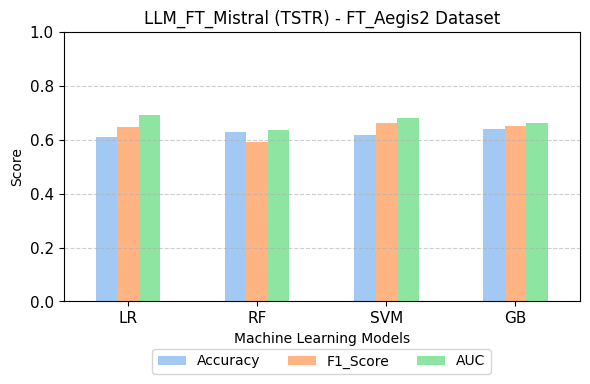

In [64]:

ml.plot_ml_comparison(results_aegis_df, "TSTR", title=f"{GAN_method} (TSTR) - FT_Aegis2 Dataset")

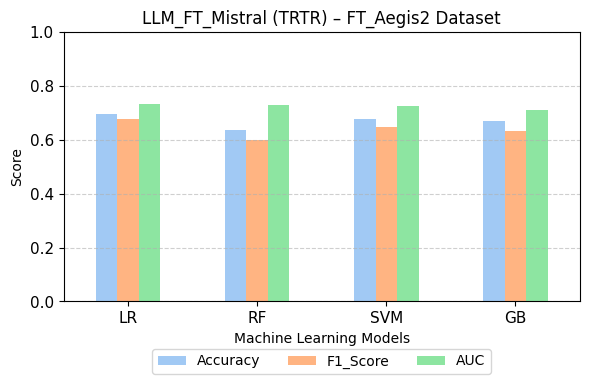

In [65]:
ml.plot_ml_comparison(results_aegis_df, "TRTR", title=f"{GAN_method} (TRTR) – FT_Aegis2 Dataset")

### Fidelity evaluation (Statistical Similarity)

- Use Statistical similarity to evaluate the quality of synthetic data:
    - Distribution similarity metrics
    - Kolmogorov-Smirnov (KS test)

1.	Plots KDEs
2.	Prints summary stats (mean, std, ...)
3.	Runs Wasserstein + KS test  
4.  plot TSNE 

### Explore synthetic data for wildGuardmix - Generated from Mistral model

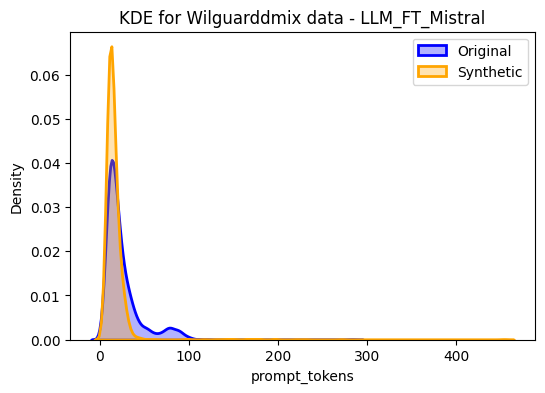

In [67]:
#title = "Aegis2 data - LLM_Mistral"
title = "Wilguarddmix data - LLM_FT_Mistral"
ml.plot_KDE(original_df, synth_df, "prompt_tokens", title = title)

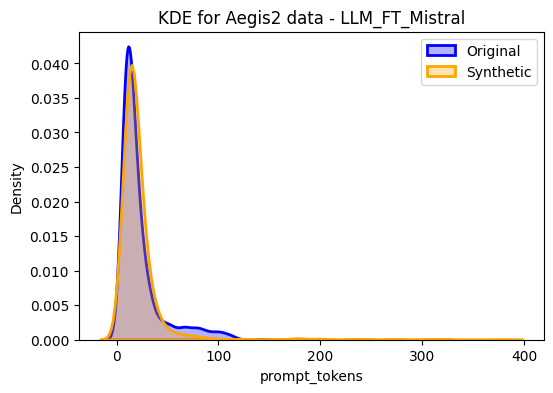

In [68]:
title = "Aegis2 data - LLM_FT_Mistral"

ml.plot_KDE(original_aegis_df, synth_aegis_df, "prompt_tokens", title = title)

In [69]:
# wildguardmix data
features = ["prompt_tokens"]  
comparison_tbl = ml.compare_summary_stats_table(original_df, synth_df, features)
comparison_tbl.head(10)

Original  Synthetic
feature       statistic                     
prompt_tokens count      2600.000   2525.000
              mean         24.628     16.025
              std          20.312     17.341
              median       18.000     13.000
              min           3.000      5.000
              max         283.000    454.000
              q1           12.000     11.000
              q3           29.000     18.000

In [70]:
# Aegis data
features = ["prompt_tokens"]  
comparison_tbl = ml.compare_summary_stats_table(original_aegis_df, synth_aegis_df, features)
comparison_tbl.head(10)

Original  Synthetic
feature       statistic                     
prompt_tokens count      1600.000   1578.000
              mean         22.282     22.395
              std          21.464     29.469
              median       15.000     16.000
              min           4.000      4.000
              max         138.000    378.000
              q1           10.000     12.000
              q3           24.000     22.000

{'dataset': 'Wilguarddmix', 'GAN_method': 'LLM_FT_Mistral', 'feature': 'prompt_tokens', 'n_real': 2600, 'n_synth': 2525, 'wasserstein_distance': 9.817711348057877, 'ks_stat': 0.26903655750190403, 'ks_pvalue': 4.712336224202495e-82}


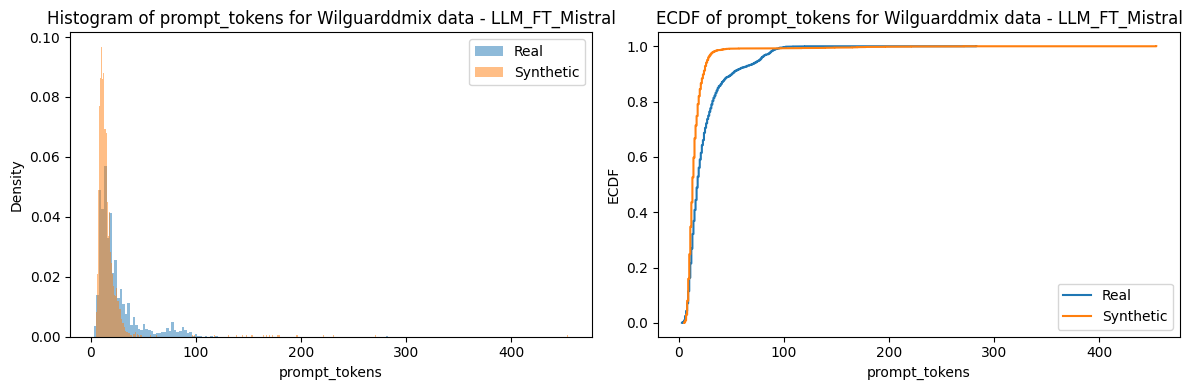

In [ ]:
# ---- Example usage ----
#title = "Aegis2 data - LLM_FT_Mistral"
title = "Wilguarddmix data - LLM_FT_Mistral"
dataset = "Wilguarddmix"
GAN_method = "LLM_FT_Mistral"
all_results = []

res = ml.compare_prompt_lengths(dataset, GAN_method,original_df, synth_df, col="prompt_tokens")
all_results.append(res)
print(res)

ml.plot_length_distributions(original_df, synth_df, col="prompt_tokens", title =title )


{'dataset': 'Aegis2', 'GAN_method': 'LLM_FT_Mistral', 'feature': 'prompt_tokens', 'n_real': 1600, 'n_synth': 1578, 'wasserstein_distance': 5.592172845373891, 'ks_stat': 0.14295231305449937, 'ks_pvalue': 1.2480015779446117e-14}


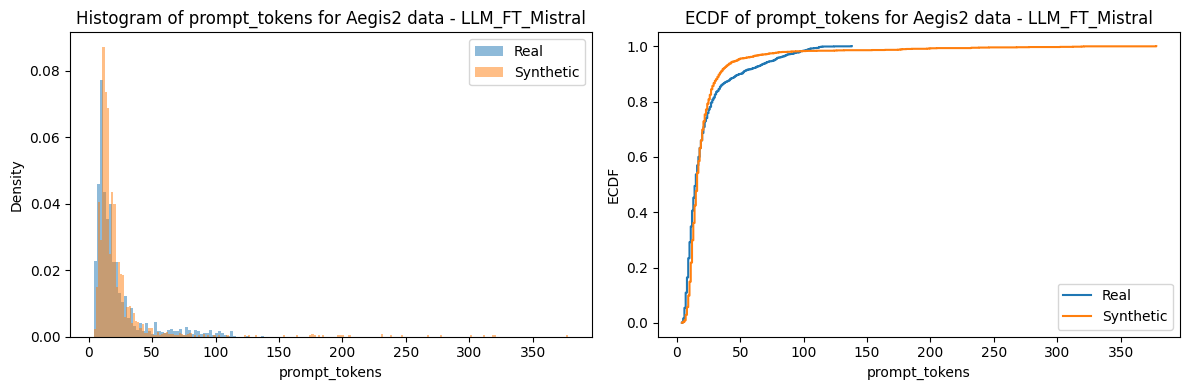

In [ ]:
# ---- Example usage ----
title = "Aegis2 data - LLM_FT_Mistral"
#title = "Wilguarddmix data - LLM_FT_Mistral"
dataset = "Aegis2"
GAN_method = "LLM_FT_Mistral"

res = ml.compare_prompt_lengths(dataset, GAN_method,original_aegis_df, synth_aegis_df, col="prompt_tokens")
all_results.append(res)
print(res)

ml.plot_length_distributions(original_aegis_df, synth_aegis_df, col="prompt_tokens", title =title )

# convert to DataFrame
results_df = pd.DataFrame(all_results)

# save to CSV
results_df.to_csv("../results/evaluation/fidelity_evalution_FT_Mistral_results.csv", index=False)

Batches: 100%|██████████| 81/81 [01:05<00:00,  1.23it/s]


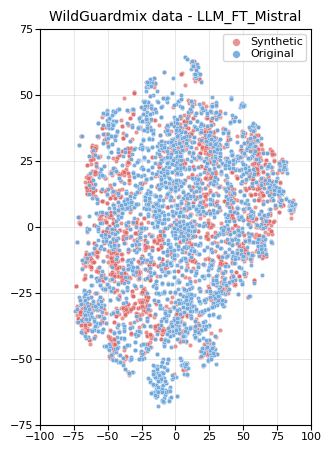

In [ ]:
ml.plot_TSNE_small(dataset, original_df, synth_df, title="WildGuardmix data - LLM_FT_Mistral")

Batches: 100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


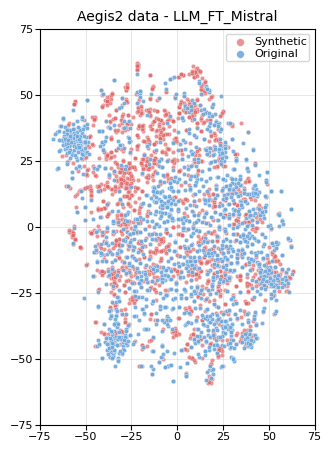

In [ ]:
ml.plot_TSNE_small(dataset, original_aegis_df, synth_aegis_df, title="Aegis2 data - LLM_FT_Mistral")
#original_df, synth_df, title=None